# Machine Learning and Classification : Rapport de projet
*Par BENAMIRA Adrien, CARRIÉ Hanaé et DEVILLERS Benjamin*

 <img src="figures/dreemcentralesupeleclogo.png" alt="Schéma simplifié de l'algorithme du  Random Forest" title="Schéma simplifié de l'algorithme du  Random Forest" style="width: 300px" />

## PLAN :

(donné par le prof.)   
a. L'étape de prétraitement des données  
b. L'extraction de features (s'il en est)  
c. Une description théorique (et aussi pédagogique que possible) du modèle utilisé  
d. Le protocole de validation croisée utilisée  
e. Présentation des résultats, figures, etc....

## 1. Introduction

Ce projet a pour but de proposer d'utiliser les données du bandeau de Dreem pour évaluer le stade de sommeil sur des périodes de 30 secondes de signaux biophysiologiques.


Le sommeil joue un rôle vital dans la santé et le bien-être d'une personne. Le sommeil progresse selon des cycles qui impliquent plusieurs stades de sommeil : réveil, sommeil léger, sommeil profond, sommeil paradoxal et à chaque stades du sommeil sont associés différentes fonctions physiologiques. Déterminer ce stade est indispensable pour diagnostiquer les troubles du sommeil. Aujourd'hui, les études polysomnographiques sont menées dans un hôpital ou dans un laboratoire du sommeil etde multiples signaux physiologiques sont enregistrés comme l'électroencéphalogramme, l'électrocardiogramme, etc. L'évaluation de l'étape du sommeil est ensuite effectué visuellement par un expert sur les époques de 30 secondes d'enregistrement des signaux. Le graphique qui en résulte est appelé hypnogramme. 


Le bandeau Dreem permet de faire de la polysomnographie à domicile grâce à trois types de capteurs : électroencéphalogramme (EEG), pouls et signaux accélérométriques. Les données mesurées par Dreem ont été labélisés par un expert en sommeil qualifié.

Le but de cet compétition Kaggle est de développer un algorithme pour classifier les phases de sommeil Wake, N1, N2, N3 et REM sur des fenêtres de 30 secondes de données brutes. Elles comprennent 7 canaux eegs en position frontale et occipitale, 1 canal infrarouge d'oxymètre de pouls et 3 canaux accéléromètres (x, y et z).


## 2. Chargement des données et pré-traitements

### 2.1. Chargement des données

Les données sont sauvegardée au format HDF5. Ce format est particulièrement intéressant car il permet de stocker des lourdes données compréssées en un dataset. La bibliothèque Python `h5py` permet de pouvoir les lire ces données facilement de la même manière que nous utiliserions un tableau `Numpy`.

La class python `DreemDataset` dans le package `tools.data` permet de récupérer et manipuler les datasets.
Comme nous voulons effectuer des prétraitements sur nos données et les stocker pour pouvoir rapidement appliquer les algorithmes d'apprentissage sur nos données traitées, nous avons conçu cette classe de sorte que nous puissions appliquer puis sauvegarder.

Nous avons choisis de les sauvegarder ensuite dans des tableaux `npy` pour des questions de performances d'execution.

La classe python `DreemDatasets` permet quant à elle de générer un "dev set" et "train set" à partir des données. Celle-ci retourne un couple d'instance de `DreemDataset`. Puis que les différentes classes ne sont pas équilibrées, nous pouvons également ne récupérer qu'un sous-ensemble du dataset équilibré.

In [34]:
from tools.data import DreemDatasets

Les paramètres sont :

- chemin vers les données
- chemin vers les cibles
- `keep_datasets` Liste des datasets à garder, parmi les suivants :
    * `eeg_1` - EEG in frontal position sampled at 50 Hz -> 1500 values
    * `eeg_2` - EEG in frontal position sampled at 50 Hz -> 1500 values
    * `eeg_3` - EEG in frontal position sampled at 50 Hz -> 1500 values
    * `eeg_4` - EEG in frontal-occipital position sampled at 50 Hz -> 1500 values
    * `eeg_5` - EEG in frontal-occipital position sampled at 50 Hz -> 1500 values
    * `eeg_6` - EEG in frontal-occipital position sampled at 50 Hz -> 1500 values
    * `eeg_7` - EEG in frontal-occipital position sampled at 50 Hz -> 1500 values
    * `accelerometer_x` - Accelerometer along x axis sampled at 10 Hz -> 300 values
    * `accelerometer_y` - Accelerometer along y axis sampled at 10 Hz -> 300 values
    * `accelerometer_z` - Accelerometer along z axis sampled at 10 Hz -> 300 values
    * `pulse_oximeter_infrared` - Pulse oximeter infrared channel sampled at 10 Hz -> 300 values
- `split_train_val` Pourcentage pour partager le train set et validation set
- `seed` Une seed pour la reproductibilité
- `balance_data` si vrai, équilibre le dataset pour avoir le nombre de donnée par classe
- `size` Une taille maximale pour le dataset (si non renseignée, tout le dataset)
- `transforms` des transformations à appliquer aux données (voir la partie transformation)
- `transforms_val` si renseignée, `transforms` sera pour le train et `transforms_val` pour la validation. Sinon, même transformation que `transforms`.

In [36]:
train_set, val_set = DreemDatasets('dataset/train.h5', 
                                   'dataset/train_y.csv', 
                                   split_train_val=0.8, 
                                   seed=0, 
                                   keep_datasets=['eeg_1']).get()

train_set.load_data()  # Load les données en mémoire

val_set.load_data()

# Ne pas oublier de fermer les datasets
# Ne ferme que les fichiers h5. Si .load_data() a été appelé, on a toujours accès aux données !
train_set.close()
val_set.close()

Loading data in memory...
5412 in 1 datasets to load
Loading dataset eeg_1 ...
Done.
Loading data in memory...
1353 in 1 datasets to load
Loading dataset eeg_1 ...
Done.


#### 2.1.1. Récupération des données

In [37]:
data_50hz, data_10hz, target = train_set[0]  # Une valeur

# Dimension nb_datasets x tailles_features
print(data_50hz.shape)

data_50hz, data_10hz, targets = train_set[:10]  # 10 valeurs
# Dimension nb_datasets x nb_elements (=10) x tailles_features

print(data_50hz.shape)

(1, 1500)
(1, 10, 1500)


#### 2.1.2. Enregistrer un dataset

On peut utiliser la méthode `save_data` pour enregistrer dans un `.npy`. Pour des questions de mémoire, il y aura un fichier par dataset (ex, si on choisit d'ouvrir `["eeg_1", "eeg_2"]` alors il y aura deux fichiers).

Attention, le nom des fichiers ne peut pas être précisé, seulement un dossier parent.

Par exemple, avec le `save_data("dataset/test")`, on aura les fichiers :
- `dataset/test/eeg_1.npy`
- `dataset/test/eeg_2.npy`

On peut préciser le chemin vers un nouveau dossier, celui-ci sera créé.

La sauvegarde enregistre les données **transformée**. Les données brutes ne sont pas enregistrées.

In [38]:
train_set, val_set = DreemDatasets('dataset/train.h5', 'dataset/train_y.csv', 
                                   split_train_val=0.8, seed=0, keep_datasets=['eeg_1']).get()

train_set.save_data("dataset/sauvegarde/train")  # Attention, pas de / à la fin !
val_set.save_data("dataset/sauvegarde/val")

train_set.close()
val_set.close()

Saving into dataset/sauvegarde/train ...
Loading dataset eeg_1 ...
Saved.
Saving into dataset/sauvegarde/val ...
Loading dataset eeg_1 ...
Saved.


Si l'on a déjà enregistré le dataset, on peut utiliser `load_data` en précisant le dossier dans lequel sont tous les fichiers

In [39]:
train_set, val_set = DreemDatasets('dataset/train.h5', 'dataset/train_y.csv', 
                                   split_train_val=0.8, seed=0, keep_datasets=['eeg_1']).get()

# Cela remplace les données données des fichiers h5.
train_set.load_data("dataset/sauvegarde/train")  # Attention, pas de / à la fin !
val_set.load_data("dataset/sauvegarde/val")

train_set.close()
val_set.close()

data_50hz, data_10hz, target = train_set[0]

print(data_50hz.shape)

Loading data in memory...
5412 in 1 datasets to load
Loading dataset eeg_1 ...
Done.
Loading data in memory...
1353 in 1 datasets to load
Loading dataset eeg_1 ...
Done.
(1, 1500)


#### 2.1.3. Test set

On peut faire la même chose avec le test set qu'avec les autres données.

Attention à bien appeler `init()`.

In [40]:
from tools.data import DreemDataset

test_set = DreemDataset('dataset/test.h5', keep_datasets=['eeg_1']).init()

# Rappel : charge en mémoire. On peut également charget un fichier en précisant un chemin
test_set.load_data()  

test_set.close()

Loading data in memory...
37439 in 1 datasets to load
Loading dataset eeg_1 ...
Done.


### 2.2. Pré-traitements

#### 2.2.1. Introduction : Transformations

Une transformation est ce qui nous permet de faire nos pré-traitements sur nos données.
Pour effectuer des transformations sur nos données, nous devons definir un dictionnaire :

In [41]:
def transformation_eeg_1(batch_signals, batch_targets):
    return batch_signals[:, 0]

transformations = {
    "eeg_1": transformation_eeg_1
}

Prenant en clé le nom du dataset sur lequel effectuer la transformation et en valeur une fonction prenant 2 paramètres :

* un batch du signal de taille (batch, taille_signal)
* les "targets" qui correspondent aux classes de sommeils que nous devons prédire pour le batch en question.

Ces deux paramètres peuvent être utiles pour nos différentes fonctions de pré-processing.

La transformation doit retourner le batch modifié.

Dans l'exemple ci-dessus, nous appliquerons une transformation au dataset `eeg_1` qui tranformera les signaux en seulement la première valeur du signal.

#### 2.2.2. Extraction en bandes

D'après [[1: Malhotra, R. K., & Avidan, A. Y. (2014). Sleep stages and scoring technique. Atlas of Sleep Medicine, 77-99.](http://www.fmed.edu.uy/sites/www.labsueno.fmed.edu.uy/files/9.Diagnostico-polisomnogr%C3%A1fico.pdf)] et [[2: Aboalayon, K., Faezipour, M., Almuhammadi, W., & Moslehpour, S. (2016). Sleep stage classification using EEG signal analysis: a comprehensive survey and new investigation. Entropy, 18(9), 272.](https://www.mdpi.com/1099-4300/18/9/272)], les électroencéphalogrames (eegs) peuvent être séparés en bande de fréquences contenant différentes informations :

* Bande $\delta$ : de 0 à 4 Hz,
* bande $\theta$ : de 4 à 8 Hz,
* bande $\alpha$ : de 8 à 13 Hz,
* bande $\beta$ : de 13 à 38 Hz,
* bande $\gamma$ : de 38 à 42 Hz.

Cependant nos eegs sont échantillonés à 50 Hz. Le thèorème de Shannon (Sampling theorem) indique que nous ne pourrons récupérer que des informations sur une bande de fréquence entre 0 et 25 Hz.

Nous ne considerons donc pour cela pas la bande $\gamma$ et gardon la bande $\beta$ que de 13 à 22 Hz.

In [42]:
from preprocessing.signals import ExtractBands

In [43]:
extract_bands = ExtractBands(bands='*')  # toutes les bandes (de delta à beta)

`extract_bands` est une transformation que nous pouvons appliquer aux eegs et qui sort des signaux extraits en bande :

In [44]:
train_set, val_set = DreemDatasets('dataset/train.h5', 
                                   'dataset/train_y.csv', 
                                   split_train_val=0.8, 
                                   seed=0, 
                                   keep_datasets=['eeg_1'],
                                   transforms={"eeg_1": extract_bands}).get()

train_set.load_data()  # Load les données en mémoire

val_set.load_data()

# Ne pas oublier de fermer les datasets
# Ne ferme que les fichiers h5. Si .load_data() a été appelé, on a toujours accès aux données !
train_set.close()
val_set.close()

data_50hz, data_10hz, target = train_set[0]

print(data_50hz.shape)

Loading data in memory...
5412 in 1 datasets to load
Loading dataset eeg_1 ...
Apply transformations...
Applied.
Done.
Loading data in memory...
1353 in 1 datasets to load
Loading dataset eeg_1 ...
Apply transformations...
Applied.
Done.
(1, 4, 1500)


Noter la dimension "4" ajoutée qui correspond aux 4 bandes de fréquence.

#### 2.2.3. Features plus avancées

Nous avons ensuite ajouté différents pré-traitements de base sur nos features tel que :

* `min` valeur min du signal,
* `max` valeur max du signal,
* `frequency` fréquence du signal,
* `energy` énergie du signal.

Puis nous avons essayé les features proposés par [[2](https://www.mdpi.com/1099-4300/18/9/272)] :
* `mmd` distance minimum-maximum
* `esis` correspond à l'énergie et "vitesse" du signal

De plus, comme expliqué par [[1](http://www.fmed.edu.uy/sites/www.labsueno.fmed.edu.uy/files/9.Diagnostico-polisomnogr%C3%A1fico.pdf)], section "_Stages of Sleep_", nous pouvons distinguer différentes étapes du sommeil par différentes prédominances "d'utilisation" d'une bande :
* `band-usage` est la feature qui indique, sur une fenêtre glissante, la bande qui est a la plus grande valeur sur la fenêtre parmi toutes les bandes. Cela donne une indication de la bande prédominante sur la fenêtre.

In [45]:
# Transformation pour ces featyres
from preprocessing.features import ExtractFeatures

# Extract features peut directement extraire les bandes
extract_features = ExtractFeatures(bands='*', features=['mmd', 'esis'])

In [46]:
train_set, val_set = DreemDatasets('dataset/train.h5', 
                                   'dataset/train_y.csv', 
                                   split_train_val=0.8, 
                                   seed=0, 
                                   keep_datasets=['eeg_1'],
                                   transforms={"eeg_1": extract_features}).get()

train_set.load_data()  # Load les données en mémoire

val_set.load_data()

# Ne pas oublier de fermer les datasets
# Ne ferme que les fichiers h5. Si .load_data() a été appelé, on a toujours accès aux données !
train_set.close()
val_set.close()

data_50hz, data_10hz, target = train_set[:]

print(data_50hz.shape)

Loading data in memory...
5412 in 1 datasets to load
Loading dataset eeg_1 ...
Apply transformations...
Applied.
Done.
Loading data in memory...
1353 in 1 datasets to load
Loading dataset eeg_1 ...
Apply transformations...
Applied.
Done.
(1, 4, 5412, 2)


On voit ici que la dimension est de 1 (=1 dataset) x 4 (=4 bandes) x nombre de signaux x 2 (=2 features).

### 2.3. Etat de l'art : Caractéristiques temporelles et spectrales à grande échelle

La classification multi-classes précise, rapide et fiable de signaux d'électroencéphalographie (EEG) est un défi pour le développement de systèmes d'interface cerveau-ordinateur (MI-BCI) d'imagerie motrice. 
C'est un domaine assez actif, comme le montre les différentes concours tel que [le concours BCI Competition IV C. Brunner et al.](http://bnci-horizon-2020.eu/database/data-sets)


Après un état de l'art efficace, plusieurs approches auraient pu etre envisagé : 

A commencé par une approche monodirectionelle concentré sur les EEGS : à partir d'une seule courbe de l'un des EEG de 30secondes déterminé sa classe et répété l'opération pour les 7 courbes (reférence : [S. Sakhav and al.](https://ieeexplore.ieee.org/document/7362882) ). Ou bien une approche multidirectionnelle concentré sur l'extraction de caractéristique qui maximisent la discriminabilité entre deux classes. 
    



Nous nous sommes attaché à exploré la seconde voie et il semblerait que la méthode la plus efficace soit celle propsosé par [Hersche et al.](https://arxiv.org/abs/1806.06823)


L'idée est d'utiliser le modèle spatial commun (CSP) et celui avec la géométrie de Riemannian pour l'étendre aux cas de multifenêtrage temporelle et spectrale.


#### 2.3.1 Filter Bank Common Spatial Pattern (FBCSP)

L'algorithme des modèles spatiaux communs (CSP) apprend des filtres spatiaux qui maximisent la discriminabilité entre deux classes ([F. Lotte and al.](https://ieeexplore.ieee.org/document/5593210)). Ses performances dépendent fortement des bandes de fréquences opérationnelles considérées. Ainsi, dans la plupart des applications, les données sont d'abord divisées en plusieurs bandes de fréquences, puis spatialement filtrées. C'est ce que l'on appelle la configuration spatiale commune des bancs de filtres. 

Dans notre cas nous utiliserons les paramètres suivants :

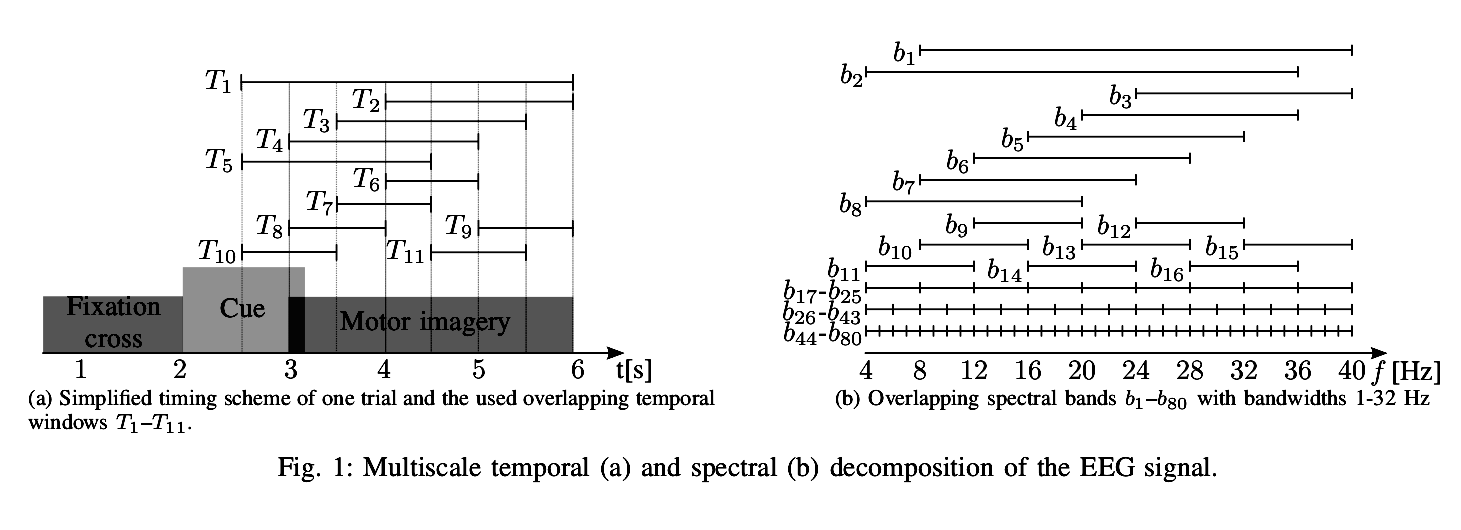

In [47]:
import os
import numpy as np
from tools.filters import load_filterbank
from IPython.display import Image
from tools.csp import generate_projection, generate_eye, extract_feature
from preprocessing import Compose, ExtractBands, ExtractSpectrum

fs = 50.  # sampling frequency
NO_channels = 7  # number of EEG channels
NO_riem = int(NO_channels * NO_channels + 1) / 2  # Total number of CSP feature per band and timewindow
bw = np.array([2, 4, 8, 13, 22])
ftype = 'butter'  # 'fir', 'butter'
forder = 2  # 4
filter_bank = load_filterbank(bw, fs, order=forder, max_freq=23, ftype=ftype)  # get filterbank coeffs
time_windows_flt = np.array([[0, 30],
                             [15, 30],
                             [10, 25],
                             [5, 20],
                             [0, 15],
                             [15, 25],
                             [10, 20],
                             [5, 15],
                             [0, 10]
]) * fs
time_windows = time_windows_flt.astype(int)
NO_bands = filter_bank.shape[0]
NO_csp = 24  # Total number of CSP feature per band and timewindow
useCSP = False

Image(os.path.join("figures","fig1.png"))

Cette figure est extraite de [Hersche et al.](https://arxiv.org/abs/1806.06823)
Pour nous, le temps varie de 0 à 30 secondes et la fréquence de 2 à 22 Herts. Le code pour appliquer ce préprocess est le suivant : 

In [8]:
def get_features(data, label, time_windows, useCSP = True):
    if useCSP:
        w = generate_projection(data, label, NO_csp, filter_bank, time_windows, NO_classes=5)
    else:
        w = generate_eye(data, label, filter_bank, time_windows)
    feature_mat = extract_feature(data, w, filter_bank, time_windows)
    return(w, feature_mat)
#w, train_feat_CSP = get_features(train_data, train_label, time_windows, useCSP)
#test_feature_CSP = extract_feature(test_data, w, filter_bank, time_windows)

#### 2.3.2 Riemannian covariance features

Nous n'irons pas dans les détails puisque nous l'avons implémenté et essayé mais ces caractéristiques donnent de (légers) moins bons résultats que les CSP features. Vous pourrez vous refairez au paragraphe 4 de la publication [Hersche et al.](https://arxiv.org/abs/1806.06823) pour plus de détails.

Voici toutefois le code à déployer pour utiliser ces features : 

In [ ]:
from models.riemannian_multiscale import riemannian_multiscale
riemann = riemannian_multiscale(filter_bank, time_windows, riem_opt=riem_opt, rho=rho, vectorized=True)
features_CSP_train_R = riemann.fit(train_data)
features_CSP_test_R = riemann.features(test_data)

### 2.4.3 Comparaison de toutes les features

Notre base de données est déséquilibré : 


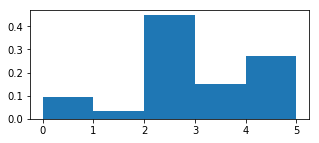

percentage per stage:  [ 9.45180078  3.53365196 44.74392123 14.96774531 27.30288072]


In [95]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,2))
label_train = np.load("dataset/data/train_label.npy")
(n, bins, patches) = plt.hist(label_train, density=True, bins=range(5+1))
plt.show()
print('percentage per stage: ', n*100)

Nous avons donc tester toutes nos features sur deux approches : un subdataset équilibré et sur tout le dataset. Pour chaque test nous utilisons la même méthode de classification : 

clf = RandomForestClassifier(n_estimators=700,max_features='auto', random_state=0)

Nous obtenons les résultats suivant (cf All_features_method.ipynb et All_features_method_balanced.ipynb) : 

In [23]:
import pandas as pd

df_all = pd.DataFrame({'Différents models sur tout le dataset':['Min - max - freq - energy on pulse et accelerometre','Min - max - freq - energy on eegs',
         'Min - max - freq - energy on all', ' Min - max - freq - energy on all + Riemann',' Min - max - freq - energy on all + CSP'], 
 'F1-score val':[0.518054836809841, 0.5632674016257432, 0.5893988863012602, 0.6046064049161487, 0.6178183804270211], 
 'Time' : [193,308,408, 2500, 3000]})

df_all

,Différents models sur tout le dataset,F1-score val,Time
0,Min - max - freq - energy on pulse et accelero...,0.518055,193
1,Min - max - freq - energy on eegs,0.563267,308
2,Min - max - freq - energy on all,0.589399,408
3,Min - max - freq - energy on all + Riemann,0.604606,2500
4,Min - max - freq - energy on all + CSP,0.617818,3000


In [28]:
df_balanced = pd.DataFrame({'Différents models sur un subdataset balanced':['Min - max - freq - energy on pulse et accelerometre',
                                                                           'Min - max - freq - energy on eegs',
                                                                           'Min - max - freq - energy on all',
                                                                           ' Min - max - freq - energy on all + Riemann',
                                                                           ' Min - max - freq - energy on all + CSP'], 
 'F1-score val':[0.5638819160728847, 0.6254347640147918, 0.6397347891229647, 0.6397853700614984, 0.639209140962282], 
 'Time' : [150,300, 400, 2000, 2500]})

df_balanced

,Différents models sur un subdataset balanced,F1-score val,Time
0,Min - max - freq - energy on pulse et accelero...,0.563882,150
1,Min - max - freq - energy on eegs,0.625435,300
2,Min - max - freq - energy on all,0.639735,400
3,Min - max - freq - energy on all + Riemann,0.639785,2000
4,Min - max - freq - energy on all + CSP,0.639209,2500


Malgré de meilleurs résultats pour le F1-score pour le balanced dataset (ATTENTION c'est bien le même validation set pour les 2 expériences !), nous obtenons de biens moins bons scores sur le Kaggle (environ 59%) contre 64.22% pour le all dataset avec la meilleure configuration. On en déduit que le test set doit être très proche du tran set

3. Sélection des features (caractéristiques)

# 3. Modèle de classification : évaluation, optimisation et choix

## 3.1. Principe des modèles de classification étudiés

Voici une explication théorique et aussi pédagogique que possible des différents modèles considérés.

### 3.1.1. *Random Forest*

Il s'agit d'un algorithme utilisant une technique ensembliste adaptée à la classification multi-classes et proposé en 2001 par Breiman & Cutter.

#### Principe

L'élément de base est l'**arbre décisionnel ou arbre CART** (Classi􏰂cation And Regression Tree) qui permet de décomposer le problème de classification en une suite de tests correspondant à une partition de l’espace des données en sous-régions homogènes en terme de classe.  
Il est construit de manière *récursive* à partir d'une base d'apprentissage. Ces arbres fournissent non seulement une solution au problème de classi􏰂cation mais permettent également de retracer les questions à poser pour e􏰀ffectuer ce choix.  

Les forêts sont en général plus efficaces que les simples arbres de décision, dont la construction dépend de l'échantillon initial et qui sont fortement instables, mais possèdent l'inconvénient d'être plus di􏰃fficilement interprétables.  
Une **forêt aléatoire** est un ensemble d'arbres de décision binaires dans lequel a été introduit de l'aléatoire dans le but d'obtenir des *arbres les plus décorrélés possibles*. De cette manière, on ne construit plus un seul arbre de décision mais plusieurs arbres de décision, chacun ayant ses propres caractéristiques dues à l'aléa introduit.  
Le nouveau classifi􏰂eur correspondant à la forêt aléatoire est calculé par *vote majoritaire*, soit en prenant la majorité des votes de chacun des classifi􏰂eurs. Ce n'est donc plus l'arbre qui vote, mais la forêt (aléatoire) cachée derrière.  
La forêt aléatoire constitue ainsi un modèle plus *stable* que l'arbre décisionnel.


􏰁***Random Forest*** est un type de forêt aléatoire qui consiste pour à mélanger les arbres CART, le *bagging* (*boostrap aggregating*) et le *random subspace*.  
Le principe simplifié de l'algorithme est décrit par le schéma ci-dessous (fig 1.).  
Pour chaque arbre, on tire un échantillon à partir de l'échantillon initial. A chaque noeud, on choisit aléatoirement K variables et on prend, parmi celles-ci, celle qui minimise le critère de l'algorithme CART. On laisse grandir l'arbre jusqu'à ce qu'il n'y ait plus qu'un seul élément dans chaque noeud.

<img src="figures/RandomForest.png" alt="Schéma simplifié de l'algorithme du  Random Forest" title="Schéma simplifié de l'algorithme du  Random Forest" style="width: 400px" />


#### Deux approches:  multi-classes ou *one-vs-all*

Les deux approches sont illustrées ci-dessous (fig.3).  

L'approche plus classique **multi-classes** a d'abord été testée. Le même algorithme est capable de distinguer les labels {0,1,2,3,4}.    

Puis, l'approche ***one-vs-all*** a été explorée dans laquelle on construit successivement plusieurs modèles de classification binaires. On attribue donc les labels classe par classe. Dans notre problème, l'ordre des labels à attribuer est le suivant :
1. différencier parmi les données les labels {2, ≠2} (classifieur #1) puis retirer les labels égaux à 2
2. différencier parmi le reste les labels {4, ≠4} (classifieur #2) puis retirer les labels égaux à 4
3. différencier parmi le reste les labels {3, ≠3} (classifieur #3) puis retirer les labels égaux à 3
4. différencier parmi le reste les labels {0, 1(≠0)} (classifieur #4) puis conclure  

Notons qu'aucun classifieur ne sera parfait. Ainsi, pour l'entraînement, on retire à chaque étape les données correspondant *réellement aux labels i* afin que pour l'étape suivante la base d'apprentissage ne contienne aucun de ces labels i. Mais, pour le test, on retirera les données correspondant aux *labels prédits i* par le classifieur. Le reste contiendra donc certaines erreurs (faux-positifs prédits i mais non égaux à i et faux-négatifs prédits comme non i mais égaux à i).  

<img src="figures/1vsall-or-multiclass.png" alt="Schéma simplifié de l'algorithme du  Random Forest" title="Schéma simplifié de l'algorithme du  Random Forest" style="width: 600px" />


### 3.1.2.  *Gradient Boosting Decision Tree*

#### Algorithme classique

Le **classifieur *Gradient Boosting***  combine les éléments suivants : *boosting* (renforcement), descente de gradient et arbre décisionnel. 

Le ***boosting*** pour la classification en Machine Learning consiste à construire un ensemble de classifieurs de façon **incrémentale**. A chaque étape, nous ajoutons un nouveau **sous-modèle** simple de petit **arbre décisionnel** (principe expliqué plus haut) pour éviter l'*overfitting*, qui essaie de **compenser les erreurs** faites par les sous-modèles précédents.  
Ce principe est illustré schématiquement plus bas (fig.4). L'algorithme de *gradient boosting* classique fait pousser les arbres **horizontalement**, c'est-à-dire qu'il fait croître le niveau de l'arbre.

Cette procédure de *boosting* peut être considérée comme une forme de descente de gradient.    
En effet, rappelons que la **descente en gradient** optimise une fonction de perte en appliquant la règle de mise à jour suivante à plusieurs reprises :  
\begin{equation*}
x = x = x - η∇Loss(x)
\end{equation*}
où ∇Loss(x) est le gradient de la fonction de perte et η est le taux d'apprentissage

L'observation clé à retenir ici est que le gradient (négatif) de la fonction de perte d'erreur au carré, évalué à la valeur de sortie $\hat{y}$, est le même que le résiduel (multiplié par 2) :  
\begin{equation*}
Loss(yi,\hat{y}) = (yi - \hat{y})^2  \\
-∇Loss(\hat{y}) = 2*(yi - \hat{y})  
\end{equation*}

Or, dans l'algorithme de *boosting*, on ajoute à chaque itération un sous-modèle **qui essaie d'imiter le négatif
de cette perte**, d'où le lien avec la descente de gradient. Le taux d'apprentissage η serait de 1 dans ce cas.  

<img src="figures/gradientboosting.png" alt="Schéma simplifié de l'algorithme du  Random Forest" title="Schéma simplifié de l'algorithme du  Random Forest" style="width: 350px" />

#### *Light GBM*

**Light GBM** est un gradient boosting framework qui utilise un algorithme d'apprentissage basé sur l'arbre décisionnel. Lien vers la documentation : https://lightgbm.readthedocs.io/en/latest/index.html.  
Light GBM fait pousser l'arbre **verticalement**, soit les feuilles de l'arbre, contrairement à l'agorithme classique de *gradient boosting* vu précédemment. Le principe est illustré ci-dessous (fig.5). Il choisira la feuille avec une perte ∇ maximale pour grandir. Lorsqu'on cultive la même feuille, l'algorithme de Leaf-wise peut réduire plus de pertes qu'un algorithme de niveau.

Light GBM peut gérer la grande taille des données et nécessite moins de mémoire pour fonctionner que le Gradient Boosting classique. Le préfixe  'Light' fait référence à la vitesse d'apprentissage plus élevée de l'algorithme. 
Cet algorithme est recommandé pour des grands datasets (> 10000 éléments) uniquement, ce qui est notre cas, car il est sensible à l'*overfitting* sinon.  

 <img src="figures/lgbm.png" alt="Schéma simplifié de l'algorithme du  Random Forest" title="Schéma simplifié de l'algorithme du  Random Forest" style="width: 400px" />

### 3.1.4. Comparaison *a priori* des modèles



|Algorithme               | Avantages   | Inconvénients |Usage habituel|
|-------------------------|-------------|---------------|---------------|
|Random Forest|rapidité <br> Robuste aux datasets bruités |Biaisé si classes non-équilibrées envers la classe la plus représentée |Polyvalent|
|Gradient Boosting  |Bonne précision <br>(rapidité et adapté aux grands datasets avec Light GBM) |Peut *overfitter* facilement <br> Réglage des paramètres important |Polyvalent|


## 3.2. Protocole de validation croisée pour l'évaluation de la performance

Afin d'estimer la performance du modèle entraîné, nous devons choisir un protocole de validation croisé parmi (entre autres):
- **leave-one-out (LOO)**   
On entraîne N modèles sur N-1 échantillons et on les teste respectivement sur l'échantillon retiré.
- **K-fold**  
Son principe est illustré ci-dessous pour K=5 (fig.7). On entraine K modèles (K<N) sur N(1-1/K) échantillons et on les teste respectivement sur les N/K échantillons retirés.



La validation croisée possède l'avantage d'exploiter l'ensemble du set d'entraînement. De plus, plusieurs modèles sont appris et évalués ce qui permet d'avoir une meilleure idée de la stabilité et de la performance du modèle.  
La LOO est plus coûteuse sur le plan du calcul que la validation K-fold mais cette dernière peut surestimer l'erreur de généralisation si la courbe d'apprentissage est abrupte pour la taille de la formation en question.  
En règle générale, la plupart des auteurs et données empiriques suggèrent que la validation croisée K-fold avec K=5 ou K=10 devrait être préférée à la LOO.  
In fine, nous avons opté pour la **validation croisée K-fold avec K=10**. 


<img src="figures/crossvalidation.png" alt="Schéma simplifié de l'algorithme du  Random Forest" title="Schéma simplifié de l'algorithme du  Random Forest" style="width: 500px" />



## 3.3. Réglage des hyperparamètres

Pour trouver le meilleur lot de paramètres, on réalise souvent une **recherche exhaustive par grille** d'hyperparamètres. Ici, nous avons opté pour une **recherche aléatoire**. Les deux démarches sont décrites ci-dessous (fig.8). 
La recherche aléatoire et la recherche par grille explorent exactement **le même espace de paramètres**. Le résultat des réglages de paramètres est assez similaire, tandis que le **temps d'exécution** de la recherche aléatoire est nettement inférieur.  
Pour s'assurer que les grilles de recherche sont pertinentes, on veillera à ce que le meilleur paramètre trouvé dans la grille ne soit pas un paramètre extrême de la grille.

<img src="figures/randomgridsearchcv.jpg" alt="Schéma simplifié de l'algorithme du  Random Forest" title="Schéma simplifié de l'algorithme du  Random Forest" style="width: 300px" />

Pour chaque modèle, on emploira la démarche suivante :
- sélectionner quelques paramètres à ajuster et éventuellement un ordre de priorité
- ne garder que 20% du train par soucis de rapidité et les mêmes 20% par soucis de reproductibilité
- recherche aléatoire des meilleurs hyperparamètres avec une crossvalidation K-fold avec K=3 (et non K=10, par soucis de rapidité)
- pour les meilleurs paramètres, estimer plus finement les performances avec une crossvalidation K-fold avec K=10 sur 80% du train
- enfin, entraîner le modèle avec ces mêmes paramètres sur tout le train

### 3.3.1. Random Forest

Les paramètres par défaut du modèle implémenté sur la bibliothèque scikit-learn sont :

In [24]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
rf = RandomForestClassifier()
rf_default_params = pd.DataFrame(rf.get_params(), index=["RandomForest"])
rf_default_params

,bootstrap,class_weight,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_impurity_split,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,n_jobs,oob_score,random_state,verbose,warm_start
RandomForest,True,None,gini,None,auto,None,0.0,None,1,2,0.0,warn,None,False,None,0,False


*n_estimators* (nombre d'arbres dans la forêt ) et *max_features* (taille des sous-ensembles aléatoires de caractéristiques à prendre en compte lors du fractionnement d'un nœud) sont les principaux paramètres à ajuster. On veut donc les considérer en priorité. Mais, en raison du compromis temps/qualité posé par *n_estimators*, il s'agira du dernier paramètre à estimer. Les autres paramètres qui influencent l'apprentissage sont : *max_depth*, *min_sample_leaf*, *min_sample_split* et *class_weight*.

En pratique, on ajustera les paramètres ainsi :
1. ***max_features*** : ['auto', 0.9, 0.95, 0.98, 0.99, 0.995, 0.998, 0.999, None]  
Les bonnes valeurs empiriques par défaut sont *max_features=sqrt(n_features)* pour les tâches de classification.  
Méthode : *GridSearchCV* sur la grille avec paramètres par défaut pour le reste, validation croisée K-fold avec K=5 sur 20% du train.     
Résultat : **max_features = 0.998**
2. ***max_depth*** : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], ***min_samples_leaf*** : [1, 2, 4] et ***min_samples_split*** : [2, 5, 10]   
De bons résultats sont souvent obtenus en réglant max_depth=None en combinaison avec min_samples_split=2 (c'est-à-dire lorsque les arbres sont en plein développement).   
Méthode : *RandomizeGridSearchCV* sur une grille de 100 combinaisons possibles mais 50 combinaisons aléatoirement choisies testées, avec le meilleur *max_features* et les paramètres par défaut pour le reste, validation croisée K-fold avec K=3 sur 20% du train.  
Résultats : **max_depth = None, min_samples_leaf = 2, min_samples_split = 2**
3. ***boostrap*** : [True, False], ***class_weight*** : [None, 'balanced']  
Les échantillons bootstrap sont utilisés par défaut (bootstrap=True) alors que la stratégie par défaut pour les arbres supplémentaires est d'utiliser l'ensemble des données (bootstrap=False).  
Méthode : pour chacune des quatre possibilités, validation croisée K-fold avec K=10 sur 20% du train avec les meilleurs paramètres trouvés précedemment et les paramètres par défaut pour le reste.   
Résultat : **class_weight = None**, **boostrap = True**
4. ***n_estimators*** : [750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000]  
Plus il est grand, mieux c'est, mais aussi plus il faudra de temps pour le calculer. De plus, les résultats cesseront de s'améliorer de façon significative au-delà d'un nombre critique d'arbres.  
Méthode : *GridSearchCV* sur la grille avec les meilleurs paramètres trouvés précedemment et les paramètres par défaut pour le reste, validation croisée K-fold avec K=3 sur 20% du train.     
Résultat : **n_estimators = 1500**


|Modèle                              | Moyenne F1-score sur 20% du train    | Écart-type F1-score sur 20% du train | 
|------------------------------------|----------------------|---------------------|
|Random Forest, paramètres par défaut|0.5595                |0.78                 |
|Random Forest, paramètres optimisés |0.5711                |0.93                 |

In [79]:
# load all features for train and test and train labels
import csv
label_train = np.load("dataset/data/train_label.npy")
features_train = np.load("dataset/data/all_features_train.npy")
features_test = np.load("dataset/data/all_features_test.npy")
print("shape all dataset features_train: ", features_train.shape, ", features_test: ", features_test.shape)

# final estimation on 80% of the whole dataset only
from sklearn.model_selection import train_test_split
features, X_test, label, y_test = train_test_split(features_train, label_train, test_size=0.2, random_state=0)
print("shape 20% dataset features: ", features.shape, ", X_test: ", len(label))

shape all dataset features_train:  (38289, 1366) , features_test:  (37439, 1366)
shape 20% dataset features:  (30631, 1366) , X_test:  30631


In [91]:
# random forest hyperparameter tuning
from sklearn.model_selection import cross_val_score
best_RF_params = {'max_features':0.998,
                  'min_samples_split': 2,
                  'min_samples_leaf': 2,
                  'max_depth': None,
                  'class_weight': None,
                  'bootstrap': True,
                  'n_estimators': 1500}
rf = RandomForestClassifier(**best_RF_params, random_state=0, verbose=2)
# rf_cv_score = cross_val_score(rf, features, label, cv=10, verbose=10) # final evaluation K-foldCV (K=10) on 80% of the whole dataset
# rf.fit(features_train, label_train) # train the model with best parameters on the whole dataset
# rf.predict(features_test) # apply on test set

### 3.3.2. Gradient Boosting

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb_default_params = pd.DataFrame(gb.get_params(), index=["GradientBoosting"])
gb_default_params

,criterion,init,learning_rate,loss,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_impurity_split,min_samples_leaf,...,min_weight_fraction_leaf,n_estimators,n_iter_no_change,presort,random_state,subsample,tol,validation_fraction,verbose,warm_start
GradientBoosting,friedman_mse,None,0.1,deviance,3,None,None,0.0,None,1,...,0.0,100,None,auto,None,1.0,0.0001,0.1,0,False


On ajustera tous les paramètres qui influencent le résultat en même temps à l'exception du *n_estimators*, en raison du compromis temps/qualité qu'il pose. De plus, on ne peut ajuster en même temps le *learning_rate* et *n_estimators* car il est nécessaire de trouver un compromis entre ces deux paramètres. 
 
En pratique, on ajustera les paramètres ainsi :
1. ***max_depth*** : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], ***min_sample_leaf*** : [1, 2, 4] et ***min_sample_split*** : [2, 5, 10], ***subsample*** :  [0.8, 1.0], ***learning_rate*** : [1, 0.1, 0.01, 0.001, 0.0001], ***max_features*** : ['auto', 'log2', 0.95, 0.98, 0.99, 0.995, None]  
Méthode : *RandomizeGridSearchCV* sur une grille de 100 combinaisons possibles mais 20 combinaisons aléatoirement choisies testées, avec les paramètres par défaut pour le reste, validation croisée K-fold avec K=3 sur 20% du .  
Résultats : **max_depth = 100, min_sample_leaf = 4, min_sample_split = 5, subsample = 0.8, learning_rate = 0.1, max_features = 0.99.**
2. ***n_estimators*** : [500, 700, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750]  
  Méthode : *GridSearchCV* sur la grille avec les meilleurs paramètres trouvés précedemment et les paramètres par défaut pour le reste, validation croisée K-fold avec K=3 sur 20% du train.     
Résultat : **n_estimators = 1500**

In [92]:
# gradient boosting hyperparameter tuning
best_GB_params = {'subsample': 0.8,
                  'min_samples_split': 5,
                  'min_samples_leaf': 4,
                  'max_features': 0.99,
                  'max_depth': 100,
                  'learning_rate': 0.1,
                  'n_estimators': 1500
                 }
gb = GradientBoostingClassifier(**best_GB_params, random_state=0, verbose=2)
# gb_cv_score = cross_val_score(gb, features, label, cv=10, verbose=10) # final evaluation K-foldCV (K=10) on 80% of the whole dataset
# gb.fit(features_train, label_train) # train the model with best parameters on the whole dataset
# y_pred_gb = gb.predict(features_test) # apply on test set

## 3.4. Autres tentatives

In [ ]:
## One-vs-all


In [ ]:
# Light gbm 
import lightgbm as lgb
X_train, X_test, y_train, y_test = train_test_split(features_train, label_train, test_size=0.33, random_state=42)
model = lgb.LGBMClassifier(objective='binary', reg_lambda=10,n_estimators=10000)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50)
y_pred_lgbm = model.predict(features_test)

# 4.  Comparaison, choix des modèles & synthèse des résultats

Pour évaluer l'augmentation de la performance entre les paramètres par défaut et ces paramètres ajustés, on regarde l'évolution du F1-score entre avec une validation croisée K-fold, K=10 sur 80% du training set. 

|Modèle et paramètres  | Résultat de F1-score moyen sur 80% du dataset en CV  | Résultat en F1-score en soumission | 
|------------------------------------|-----------------------------|------------------------------------|
|Random Forest, paramètres par défaut| 0.61330                     | 0.64223                             |
|Random Forest, paramètres optimisés | 0.62951                     | 0.64303                 | 
|Random Forest OneVSall              |                                          |                 | 
|Gradient Boosting, paramètres par défaut|                         | 0.63320                               |
|Gradient Boosting, paramètres optimisés |                         |                 |  
|Light GBM                       |          0.67140                    | 0.64554                 | 

Ce tableau récapitulatif permet de constater que la richesse des *features* permet d'obtenir de bons f1-scores même avec les paramètres par défaut des différents modèles. L'apport du réglage des hyperparmètres sur les résultats est relativement faible.  
Les modèles les plus intéressants à conserver paraissent être le Light GBM qui donne les meilleurs résultats en soumission (soit sur 50% du test) ainsi que le Random Forest avec les paramètres optimisés.
